# 掃Gate量IV 

In [1]:
import numpy as np
import pandas as pd
import pyvisa as visa
import matplotlib.pyplot as plt
import my_SR830
import os, time, threading, datetime, pymeasure,tqdm

from tqdm import trange,tqdm
from time import sleep
from datetime import date
from IPython import display
from pymeasure.adapters import VISAAdapter
from pathlib import Path

import qcodes as qc
import qcodes.instrument_drivers.QDevil.QDevil_QDAC as QDac
from qcodes.instrument_drivers.QDevil.QDevil_QDAC import Mode

print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
visa.ResourceManager().list_resources()

C:\Users\USER\Anaconda3\lib\site-packages\visa.py:23: FutureWarning: The visa module provided by PyVISA is being deprecated. You can replace `import visa` by `import pyvisa as visa` to achieve the same effect.

The reason for the deprecation is the possible conflict with the visa package provided by the https://github.com/visa-sdk/visa-python which can result in hard to debug situations.
  FutureWarning,


2021-04-04 19:19:12


('ASRL1::INSTR',
 'ASRL2::INSTR',
 'ASRL3::INSTR',
 'ASRL10::INSTR',
 'GPIB0::8::INSTR')

## 讀取830和QDac

In [2]:
SR830_GPIB_Addr = 8  ##請檢察GPIB號碼
srs_source = my_SR830.MY_SR830(SR830_GPIB_Addr)

qdac = QDac.QDac(name='qdac', address='ASRL3::INSTR', update_currents=False)
print('\nQDAC succesfully connected ! :)\n')
print("Number of channels: ",qdac.num_chans)


QDAC succesfully connected ! :)

Number of channels:  24


In [3]:
# This will query voltages of all channels of a 24 channel QDAC 
# Note that index 0 refer to channel 01, 1 refer to channel 02 and so on 
def show_now_all_voltage():
    np.set_printoptions(linewidth=1000)  ##for pretty printing
    print('Channel Voltage : ')
    feed = np.around(np.reshape(np.array(qdac.channels[0:24].v()),(3,8)),decimals=3)
    print(feed)
    return feed
# qdac.print_overview(update_currents=False)

##For more information see "QCodes example with QDevil_QDAC" file


def whilegoto(m_gate,volt):
    m_gate.v.set(volt)
    while abs(volt-m_gate.v.get())>1e-4: 
        display.clear_output(wait=True)
        print("Ramping %s voltage to %.6f (V) ...\ncurrent voltage is %.6f (V)"%(m_gate,volt,m_gate.v.get()))
        m_gate.v.set(volt)
        time.sleep(2)
    display.clear_output(wait=True)
    print("Done!")
    print("%s is now at %.6f Volts"%(m_gate,m_gate.v.get()))
    return m_gate.v.get()


def reshape_for_origin(m_data,m_data_points):
    A,B = np.split(m_data,[m_data_points])
    C,D = np.split(m_data,[m_data_points-1])
    return np.hstack((A,D))


def All_Goto(AG=-1,BG_left=-1,BG_right=-1,EG=-1):
    preramp_voltage_array = np.around(
                                    np.delete(
                                        np.array(qdac.channels[0:24].v())
                                        ,[0,1,3,5,7,8,10,12,14,16,17,18,19,20,21,22,23])
                                    ,decimals=4)

    EG3.v.set(EG)
    EG4.v.set(EG)
    AG45.v.set(EG)
    AG56.v.set(AG)
    BG4.v.set(EG)
    BG5.v.set(BG_left)
    BG6.v.set(BG_right)
    time.sleep(1)

    while 1:
        later_voltage_array = np.around(
                                    np.delete(
                                        np.array(qdac.channels[0:24].v())
                                        ,[0,1,3,5,7,8,10,12,14,16,17,18,19,20,21,22,23])
                                    ,decimals=4)

        if np.size(np.where(preramp_voltage_array == later_voltage_array))>=1:
            EG3.v.set(EG)
            EG4.v.set(EG)
            AG45.v.set(EG)
            AG56.v.set(AG)
            BG4.v.set(EG)
            BG5.v.set(BG_left)
            BG6.v.set(BG_right)
            time.sleep(1)
        else:
            break

    while abs(BG4.v.get()-EG)>1e-4:
        display.clear_output(wait=True)
        show_now_all_voltage()
        time.sleep(1)
    print('Done !')
    show_now_all_voltage()

## QDAC 設定 

In [4]:
EG3  = qdac.ch10
EG4  = qdac.ch16
AG45 = qdac.ch12
AG56 = qdac.ch14
BG4  = qdac.ch03
BG5  = qdac.ch05
BG6  = qdac.ch07
DG2  = qdac.ch02
DG3  = qdac.ch08

In [5]:
# # # # gate.slope('Inf')  ## Careful with this one.
# gate.v.set(0.0)
# gate.mode(Mode.vlow_ilow)  ## 看要檢查什麼模式 (vlow -> +-1.1V)v . !!!!! pls change mode at 0V !!!!! 

EG3.mode(Mode.vhigh_ilow)
EG4.mode(Mode.vhigh_ilow)
AG45.mode(Mode.vhigh_ilow)
AG56.mode(Mode.vhigh_ilow)
BG4.mode(Mode.vhigh_ilow)
BG5.mode(Mode.vhigh_ilow)
BG6.mode(Mode.vhigh_ilow)
DG2.mode(Mode.vhigh_ilow)
DG3.mode(Mode.vhigh_ilow)

In [6]:
# For smooth voltage changes the maximal voltage change (in V/s) may be set for each channel
m = 0.05  #### 設定走多快
EG3.slope(m)
EG4.slope(m)
AG45.slope(m)
AG56.slope(m)
BG4.slope(m)
BG5.slope(m)
BG6.slope(m)
DG2.slope(m)
DG3.slope(m)

qdac.print_slopes()

Channel 2, slope: 0.05 (V/s)
Channel 3, slope: 0.05 (V/s)
Channel 5, slope: 0.05 (V/s)
Channel 7, slope: 0.05 (V/s)
Channel 8, slope: 0.05 (V/s)
Channel 10, slope: 0.05 (V/s)
Channel 12, slope: 0.05 (V/s)
Channel 14, slope: 0.05 (V/s)
Channel 16, slope: 0.05 (V/s)


In [7]:
##Plunger (Tuned gate)
gate = AG56   ##選擇要調控的輸出端子
print("Sweeping with :",gate)  ##確認調控的閘極
gate.mode(Mode.vhigh_ilow) ### Set mode and slope again just to make sure.
gate.slope(m)
print("\t\tGate mode :",gate.mode.cache().get_label())

##Barrier
BarrierLeft = BG5  ####Choose the barriers in use
BarrierRight = BG6
print("\nBarriers with :",BarrierLeft," and ",BarrierRight)

Sweeping with : <QDacChannel: qdac_chan14 of QDac: qdac>
		Gate mode : V range high / I range low

Barriers with : <QDacChannel: qdac_chan05 of QDac: qdac>  and  <QDacChannel: qdac_chan07 of QDac: qdac>


## 830相關設定

In [8]:
SD_voltage_apply = 1

srs_goto_step = 0.05
srs_goto_delay_time=0.5
srs_source.input_config = 'A'
srs_source.input_grounding = 'Float'
srs_source.frequency = 87.11 # change the lock-in frequency
srs_source.time_constant = 0.3 # change the lock-in time constant
srs_source.sensitivity = 2e-5 # change the lock-in sensitivity
srs_source.channel1 = 'X'
srs_source.channel2 = 'Y'

# srs_source.GOTO(SD_voltage_apply, srs_goto_step, srs_goto_delay_time) #給檢查Sensitivity
# srs_source.GOTO(0.004, srs_goto_step, srs_goto_delay_time) #歸零
# Lock-in 放大率(到2000需要乘上倍數)
# senstivity 2mv = 5000倍
# 10V / senstivity

# 包一包

In [9]:
def run(v_BG5,v_BG6):
    ####量測相關設定###############################################################################################
    m_gate_voltage_apply_1,n = [],'no input'
    
    EG = 2.95
    
    m_min_V = 1.5        #initial voltage
    m_max_V = 4.0        #final voltage
    m_data_points = 501      #resolution for one sweep (m_min_V to m_max_V)

    forth = np.linspace(m_min_V, m_max_V,m_data_points)
    back = np.flip(forth,0)
    m_gate_voltage_apply_1 = forth
    m_gate_voltage_apply_1 = np.append(m_gate_voltage_apply_1[:-1],back)

    measure_wait_time = 1  #電壓到時等一段時間穩定後再量測

    N_ave = 6 #在一個電壓職重複量測幾次
    ave_wait = 2 #Lock-in 要等0.5秒才能再量
    fontsize = 8
    drawing_resolution = 10
    divider_ratio= 1e-5 #分壓比例(Source Drain SR830)
    Amplifier_gain= 1e6 #放大器比例(Source Drain SR830)
    
    ####路徑設定#####################################################################################################
    repeat = 0

    folder_path = "C:/Users/USER/Sean/2021-03-31 BGsweep/" ##儲存的地方
    file_name = 'BG5at_%sV_BG6at_%sV_repeat%s_at_%s_Dot_Under_AG56'%(v_BG5,v_BG6,repeat,date.today())##儲存的檔名
    print('檔名會叫做 >> %s'%file_name) 

    overwrite = 'Y'
    if os.path.isfile('%s%s.txt'%(folder_path,file_name))==True:
        overwrite = input('Do you want to overwtite the existing file? >>> Y/N  ')
    if overwrite == 'Y'or 'y':
        file_name = file_name
    else:
        file_name = '##'
        print("please create a new file")
        raise RuntimeError('!!!!  File exsit, please name a new file  !!!!')

    ####調整Barrier和AG電壓##############################################################################################
    All_Goto(m_min_V,v_BG5,v_BG6,EG)
#     whilegoto(BarrierLeft,v_BG5)
#     whilegoto(BarrierRight,v_BG6)
    whilegoto(gate,m_gate_voltage_apply_1[0]+0.01)
    time.sleep(1)
    print('Voltage before measurement was ...')
    V_before = show_now_all_voltage()

    ####開始量測迴圈######################################################################################################
    current_measure_xx = np.zeros((len(m_gate_voltage_apply_1), N_ave+1)) #製造0矩陣以放入量測數據
    conductance_measure_xx = np.zeros((len(m_gate_voltage_apply_1), N_ave+1))
    current_qdac_measure_xx = np.zeros((len(m_gate_voltage_apply_1), N_ave+1))
    voltage_qdac_measure_xx = np.zeros((len(m_gate_voltage_apply_1), N_ave+1))
    plt.figure(figsize=(3,3), dpi=200)  ##create empty graph
    plt.xlim([m_min_V,m_max_V])

    start = time.time()
    print("Apply Gate voltage...")
    for index_V, voltage in enumerate(tqdm(m_gate_voltage_apply_1)): #####開始掃GATE(P1)並量測記錄
        
        gate.v.set(voltage)
        time.sleep(0.5)
        while abs(voltage-gate.v.get())>1e-4: 
            gate.v.set(voltage)
            time.sleep(1)

        time.sleep(measure_wait_time)  ## wait a while before measurement
        Sum_of_current, Sum_of_conductance, Sum_of_current_qdac,  Sum_of_voltage_qdac = 0, 0, 0, 0

        ###量測################################################################
        for n in range(N_ave):
            current_measure_xx[index_V,n] = srs_source.x/Amplifier_gain   ##讀取Lock_in的值  絕對值:srs_source.magnitude
            conductance_measure_xx[index_V,n] = srs_source.x/Amplifier_gain/(SD_voltage_apply*divider_ratio)
            current_qdac_measure_xx[index_V,n] = gate.i()
            voltage_qdac_measure_xx[index_V,n] = gate.v.get()

            Sum_of_current += current_measure_xx[index_V,n]
            Sum_of_conductance += conductance_measure_xx[index_V,n]
            Sum_of_current_qdac += current_qdac_measure_xx[index_V,n]
            Sum_of_voltage_qdac += voltage_qdac_measure_xx[index_V,n]

            time.sleep(ave_wait) ## Lockin delay at least 0.5s

        current_measure_xx[index_V,N_ave] = Sum_of_current/float(N_ave) #加上平均數值
        conductance_measure_xx[index_V,N_ave] = Sum_of_conductance/float(N_ave) #加上平均數值
        current_qdac_measure_xx[index_V,N_ave] = Sum_of_current_qdac/float(N_ave)
        voltage_qdac_measure_xx[index_V,N_ave] = Sum_of_voltage_qdac/float(N_ave)

        ####畫圖################################################################
        if (index_V%drawing_resolution==0):
            display.clear_output(wait=True)

            plt.subplot(4,1, 1)
            plt.plot(m_gate_voltage_apply_1[:index_V+1] , current_measure_xx[:index_V+1,N_ave], c='r')#, label='$\\rho_{xy} pin 2-11$')
            plt.xlabel("$V$ (V)")
            plt.xticks(fontsize=fontsize)
            plt.ylabel("$I$ (A)")
            plt.yticks(fontsize=fontsize)

            plt.subplot(4,1, 2)
            plt.plot(m_gate_voltage_apply_1[:index_V+1] , conductance_measure_xx[:index_V+1,N_ave], c='r')#, label='$\\rho_{xy} pin 2-11$')
            plt.xlabel("$V$ (V)")
            plt.xticks(fontsize=fontsize)
            plt.ylabel("$G$ (S)")
            plt.yticks(fontsize=fontsize)
            display.display(plt.gcf())

    time.sleep(0.01)
    print("Measurement ends.")
    display.clear_output(wait=True)

    plt.subplot(4,1, 1)
    plt.plot(m_gate_voltage_apply_1 , current_measure_xx[:,N_ave], c='r')#, label='$\\rho_{xy} pin 2-11$')
    #plt.ylim([voltage_measure.min(),voltage_measure.max()])
    plt.xlabel("$V$ (V)")
    plt.xticks(fontsize=fontsize)
    plt.ylabel("$I$ (A)")
    plt.yticks(fontsize=fontsize)

    plt.subplot(4,1, 2)
    plt.plot(m_gate_voltage_apply_1 , conductance_measure_xx[:,N_ave], c='r')#, label='$\\rho_{xy} pin 2-11$')
    #plt.ylim([voltage_measure.min(),voltage_measure.max()])
    plt.xlabel("$V$ (V)")
    plt.xticks(fontsize=fontsize)
    plt.ylabel("$G$ (S)")
    plt.yticks(fontsize=fontsize)
    # plt.savefig('%s/Rxx.png'%folder_path[index_current],bbox_inches='tight', dpi=200, pad_inches=0.05) ##存圖片
    display.display(plt.gcf())
    
    ####存檔############################################################################################################
    voltage_log = np.hstack((m_gate_voltage_apply_1.reshape(-1,1), voltage_qdac_measure_xx[:, -1].reshape(-1,1),
                             m_gate_voltage_apply_1.reshape(-1,1)-voltage_qdac_measure_xx[:, -1].reshape(-1,1),
                             (m_gate_voltage_apply_1.reshape(-1,1)-voltage_qdac_measure_xx[:, -1].reshape(-1,1))/m_gate_voltage_apply_1.reshape(-1,1)*100))

    raw_data = np.hstack((voltage_qdac_measure_xx, current_measure_xx, conductance_measure_xx,
                          current_qdac_measure_xx,m_gate_voltage_apply_1.reshape(-1,1)))

    data = np.hstack((voltage_qdac_measure_xx[:,[-1]], current_measure_xx[:,[-1]], conductance_measure_xx[:,[-1]], 
                      current_qdac_measure_xx[:,[-1]], m_gate_voltage_apply_1.reshape(-1,1)))
    
    data = reshape_for_origin(data, m_data_points)

    np.savetxt("%svoltage_log%s.txt" %(folder_path,file_name),voltage_log,comments='', fmt="%.8e", \
               header='v_set\tv_actual\terror\terror_percentage\
               \n(V)\t(V)\t(V)\t(%)')

    np.savetxt("%sraw_data%s.txt" %(folder_path,file_name),raw_data,comments='', fmt="%.8e", \
               header='V\tI*%d\tI_avg\tG*%d\tG_avg\tV_set\
               \n(V)\t(A)\t(A)\t(S)\t(s)\t(V)'%(N_ave,N_ave))

    np.savetxt('%s%s.txt'%(folder_path,file_name),data, fmt="%.8e",comments='',\
               header='Vag\tId_avg_of_%s\tG_avg_of_%s\tQDACcurrent\tV_set \
               \n(V)\t(A)\t(S)\t(A)\V_set(V)\
               \nfrom%sVto%sV\tresolution_%.3f(V)\tBG=%sV_and_%sV\tleakage_current\tset_V\tback_to_%s\tback_to_%s\tback_to_%s\tback_to_%s\tback_to_%s\t%spoints\tmeasure_wait_time_%s\tslope_%s'\
               %(N_ave,N_ave,\
                             \
                 m_min_V,m_max_V,(m_max_V-m_min_V)/(m_data_points-1),v_BG5,v_BG6,m_min_V,m_min_V,m_min_V,m_min_V,m_min_V,m_data_points,measure_wait_time,m))
    
    ################################################################################################################
    V_after = show_now_all_voltage()
    print('Going back to -1 V ...')
    All_Goto()
    stop = time.time()
    T=(stop-start)/60
    display.clear_output(wait=True)
    print("Measurement ends.\n這次量測花費了 %f 分鐘\nDONE!!!\n"%T)
    print("Voltage before measurement : ")
    print(V_before)
    print("Voltage after measurement : ")
    print(V_after)
    show_now_all_voltage()

## 輸入需要的 Barrier 電壓  e.g.  run(BG5,BG6)

In [10]:
# def Everyone_goto(v_set):
#     1. read value of each channel for 2 sec and sdd if any channel is stuck (striaght forward but slow)
#     2. read sum of all value and compare expected rate (fast but error prone)
#     3. read value before ramp and compare value after 2 sec. (probably better?)
#     return print("all channels ramping correctly")

In [11]:
show_now_all_voltage()
display.clear_output(wait=True)

Channel Voltage : 
[[-0. -0. -1. -0. -1.  0. -1.  0.]
 [-0. -1.  0. -1.  0. -1.  0. -1.]
 [ 0. -0.  0.  0. -0. -0.  0.  0.]]


In [ ]:
All_Goto()

Measurement ends.
這次量測花費了 327.871253 分鐘
DONE!!!

Voltage before measurement : 
[[-0.   -0.    2.95 -0.    1.35  0.    1.4   0.  ]
 [-0.    2.95  0.    2.95  0.    1.51  0.    2.95]
 [ 0.   -0.    0.    0.   -0.   -0.    0.    0.  ]]
Voltage after measurement : 
[[-0.   -0.    2.95 -0.    1.35  0.    1.4   0.  ]
 [-0.    2.95  0.    2.95  0.    1.5   0.    2.95]
 [ 0.   -0.    0.    0.   -0.   -0.    0.    0.  ]]
Channel Voltage : 
[[-0. -0. -1. -0. -1.  0. -1.  0.]
 [-0. -1.  0. -1.  0. -1.  0. -1.]
 [ 0. -0.  0.  0. -0. -0.  0.  0.]]


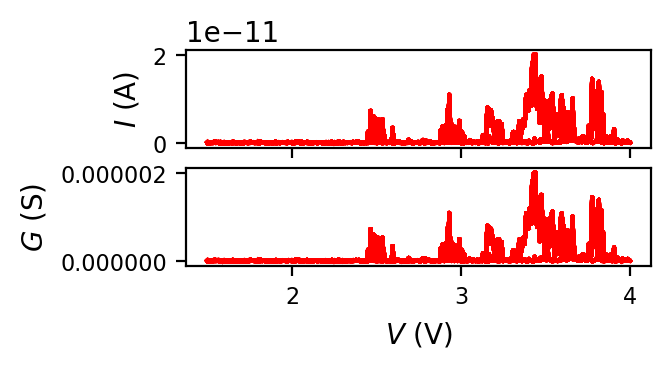

In [12]:
run(1.35,1.4)

Measurement ends.
這次量測花費了 325.671285 分鐘
DONE!!!

Voltage before measurement : 
[[-0.   -0.    2.95 -0.    1.35  0.    1.45  0.  ]
 [-0.    2.95  0.    2.95  0.    1.51  0.    2.95]
 [ 0.   -0.    0.    0.   -0.   -0.    0.    0.  ]]
Voltage after measurement : 
[[-0.   -0.    2.95 -0.    1.35  0.    1.45  0.  ]
 [-0.    2.95  0.    2.95  0.    1.5   0.    2.95]
 [ 0.   -0.    0.    0.   -0.   -0.    0.    0.  ]]
Channel Voltage : 
[[-0. -0. -1. -0. -1.  0. -1.  0.]
 [-0. -1.  0. -1.  0. -1.  0. -1.]
 [ 0. -0.  0.  0. -0. -0.  0.  0.]]


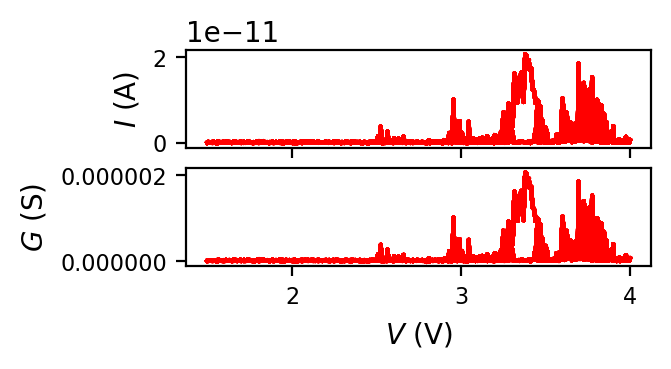

In [13]:
run(1.35,1.45)

Measurement ends.
這次量測花費了 320.587343 分鐘
DONE!!!

Voltage before measurement : 
[[-0.   -0.    2.95 -0.    1.4   0.    1.35  0.  ]
 [-0.    2.95  0.    2.97  0.    1.51  0.    2.95]
 [ 0.   -0.    0.    0.   -0.   -0.    0.    0.  ]]
Voltage after measurement : 
[[-0.   -0.    2.95 -0.    1.4   0.    1.35  0.  ]
 [-0.    2.95  0.    2.97  0.    1.5   0.    2.95]
 [ 0.   -0.    0.    0.   -0.   -0.    0.    0.  ]]
Channel Voltage : 
[[-0. -0. -1. -0. -1.  0. -1.  0.]
 [-0. -1.  0. -1.  0. -1.  0. -1.]
 [ 0. -0.  0.  0. -0. -0.  0.  0.]]


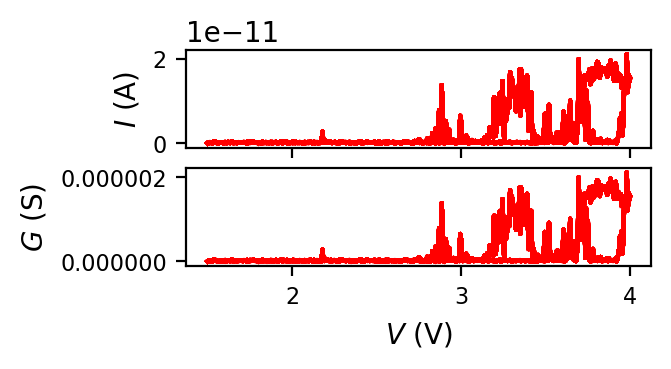

In [14]:
run(1.4,1.35)

Measurement ends.
這次量測花費了 315.735375 分鐘
DONE!!!

Voltage before measurement : 
[[-0.   -0.    2.95 -0.    1.4   0.    1.45  0.  ]
 [-0.    2.95  0.    2.95  0.    1.51  0.    2.95]
 [ 0.   -0.    0.    0.   -0.   -0.    0.    0.  ]]
Voltage after measurement : 
[[-0.   -0.    2.95 -0.    1.4   0.    1.45  0.  ]
 [-0.    2.95  0.    2.95  0.    1.5   0.    2.95]
 [ 0.   -0.    0.    0.   -0.   -0.    0.    0.  ]]
Channel Voltage : 
[[-0. -0. -1. -0. -1.  0. -1.  0.]
 [-0. -1.  0. -1.  0. -1.  0. -1.]
 [ 0. -0.  0.  0. -0. -0.  0.  0.]]


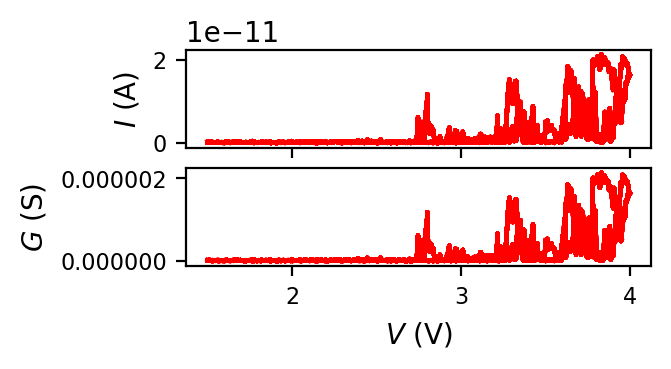

In [15]:
run(1.4,1.45)

Measurement ends.
這次量測花費了 329.013484 分鐘
DONE!!!

Voltage before measurement : 
[[-0.   -0.    2.95 -0.    1.45  0.    1.35  0.  ]
 [-0.    2.95  0.    2.95  0.    1.51  0.    2.95]
 [ 0.   -0.    0.    0.   -0.   -0.    0.    0.  ]]
Voltage after measurement : 
[[-0.   -0.    2.95 -0.    1.45  0.    1.35  0.  ]
 [-0.    2.95  0.    2.95  0.    1.5   0.    2.95]
 [ 0.   -0.    0.    0.   -0.   -0.    0.    0.  ]]
Channel Voltage : 
[[-0. -0. -1. -0. -1.  0. -1.  0.]
 [-0. -1.  0. -1.  0. -1.  0. -1.]
 [ 0. -0.  0.  0. -0. -0.  0.  0.]]


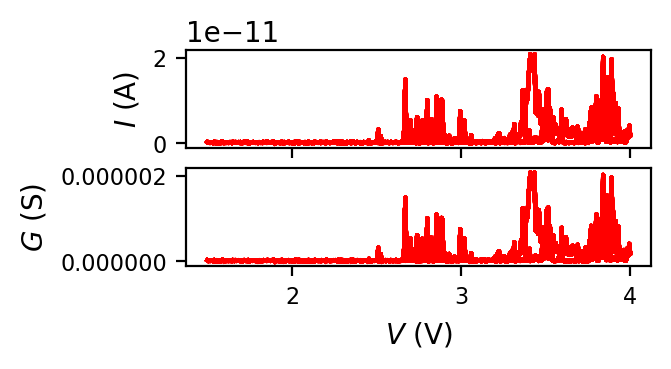

In [16]:
run(1.45,1.35)

Measurement ends.
這次量測花費了 325.631677 分鐘
DONE!!!

Voltage before measurement : 
[[-0.   -0.    2.95 -0.    1.45  0.    1.4   0.  ]
 [-0.    2.95  0.    2.97  0.    1.51  0.    2.95]
 [ 0.   -0.    0.    0.   -0.   -0.    0.    0.  ]]
Voltage after measurement : 
[[-0.   -0.    2.95 -0.    1.45  0.    1.4   0.  ]
 [-0.    2.95  0.    2.97  0.    1.5   0.    2.95]
 [ 0.   -0.    0.    0.   -0.   -0.    0.    0.  ]]
Channel Voltage : 
[[-0. -0. -1. -0. -1.  0. -1.  0.]
 [-0. -1.  0. -1.  0. -1.  0. -1.]
 [ 0. -0.  0.  0. -0. -0.  0.  0.]]


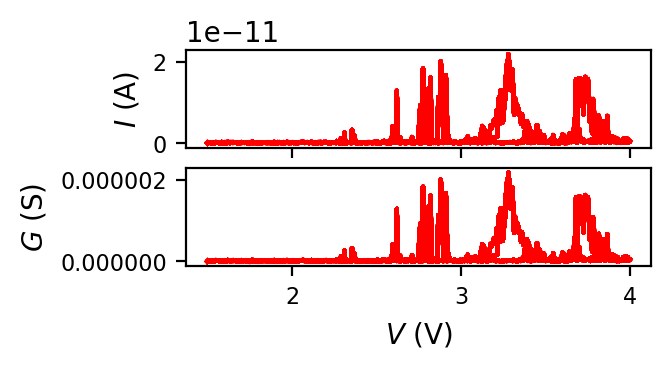

In [17]:
run(1.45,1.4)

Measurement ends.
這次量測花費了 321.612669 分鐘
DONE!!!

Voltage before measurement : 
[[-0.   -0.    2.95 -0.    1.45  0.    1.45  0.  ]
 [-0.    2.95  0.    2.95  0.    1.51  0.    2.95]
 [ 0.   -0.    0.    0.   -0.   -0.    0.    0.  ]]
Voltage after measurement : 
[[-0.   -0.    2.95 -0.    1.45  0.    1.45  0.  ]
 [-0.    2.95  0.    2.95  0.    1.5   0.    2.95]
 [ 0.   -0.    0.    0.   -0.   -0.    0.    0.  ]]
Channel Voltage : 
[[-0. -0. -1. -0. -1.  0. -1.  0.]
 [-0. -1.  0. -1.  0. -1.  0. -1.]
 [ 0. -0.  0.  0. -0. -0.  0.  0.]]


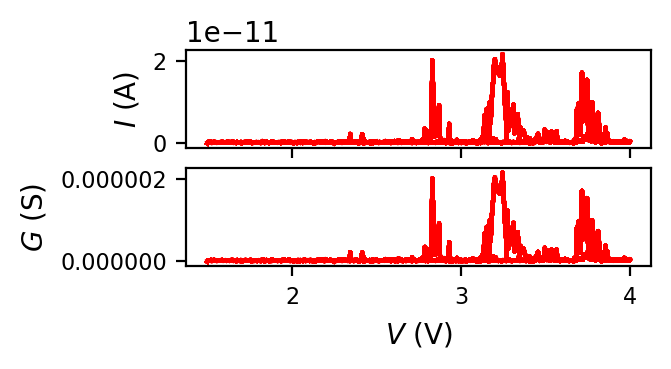

In [18]:
run(1.45,1.45)

Measurement ends.
這次量測花費了 325.690800 分鐘
DONE!!!

Voltage before measurement : 
[[-0.   -0.    2.95 -0.    1.4   0.    1.4   0.  ]
 [-0.    2.95  0.    2.95  0.    1.51  0.    2.95]
 [ 0.   -0.    0.    0.   -0.   -0.    0.    0.  ]]
Voltage after measurement : 
[[-0.   -0.    2.95 -0.    1.4   0.    1.4   0.  ]
 [-0.    2.95  0.    2.95  0.    1.5   0.    2.95]
 [ 0.   -0.    0.    0.   -0.   -0.    0.    0.  ]]
Channel Voltage : 
[[-0. -0. -1. -0. -1.  0. -1.  0.]
 [-0. -1.  0. -1.  0. -1.  0. -1.]
 [ 0. -0.  0.  0. -0. -0.  0.  0.]]


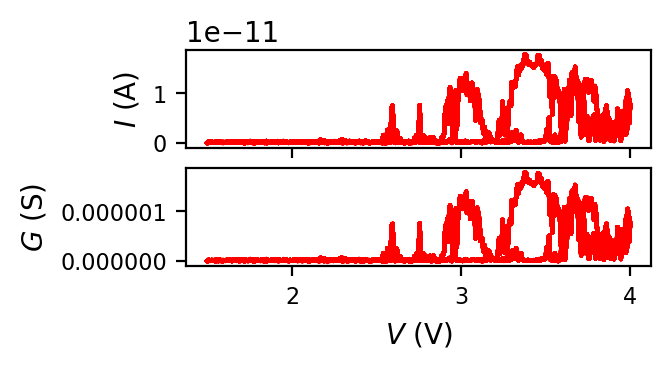

In [19]:
run(1.4,1.4)

# 如有需要檢查電壓輸出可使用

In [ ]:
# pd.set_option('display.max_rows', None)
# pd.DataFrame(voltage_log,columns=['v_set', 'v_actual', 'error','error_rate (%)'])

In [ ]:
# np.set_printoptions(precision=3)
# arr = (gate_voltage_apply_1.reshape(-1,1)-voltage_qdac_measure_xx[:, -1].reshape(-1,1))\
# /gate_voltage_apply_1.reshape(-1,1)*100 
# #### 調 decimal 當作判斷標準 可以知道有幾組電壓誤差超過此標準
# pd.DataFrame(np.around(arr,decimals=3),columns=['error_rate (%)'])  ## Ctrl+F 0.000 for quick find